In [325]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from scipy.stats import normaltest, shapiro
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)
pd.set_option("display.max_colwidth", 200)

In [326]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

For reference: https://nbviewer.jupyter.org/github/IncioMan/socialdata/blob/master/FinalProject/TrafficDataProject.ipynb

### Import

**Tags**

In [327]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.head()

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7
2,2015-04-23 00:00:00,5.1,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,2015-04-02 08:09:45,4,2015,5,5.1
3,NaN,5.1.1,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2015-06-02 08:34:06,6,2015,5,5.1.1
4,NaN,5.1.2,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,2015-07-27 08:03:21,7,2015,5,5.1.2


In [328]:
methods= ["direct_and_pr", "iterative_pr_head_ref_cherry_picked"]

In [329]:
direct_and_pr = pd.read_csv(f"{csv_folder}/final_datasets/{methods[0]}_with_sw_metrics.csv", index_col=0)

In [330]:
iterative_pr_head_ref_cherry_picked = pd.read_csv(f"{csv_folder}/final_datasets/{methods[1]}_with_sw_metrics.csv", index_col=0)

In [331]:
methods_df = {"direct_and_pr":direct_and_pr,
             "iterative_pr_head_ref_cherry_picked": iterative_pr_head_ref_cherry_picked}

### Features

| Variable name                            | Variable description                                                                                               | Variable type | How many      |
|------------------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------|---------------|
| ratio_{state}_build                      | Ratio number of builds in the state over all builds for the release                                                | Continuous    | 4             |
| ratio_pr_build                           | Ratio number of pull request builds in the state over all builds for the release                                   | Continuous    | 1             |
| {aggr}_{state}_build_duration            | Aggregation for the duration of the builds in that state for the release                                           | Continuous    | 4 \* 3 = 12   |
| {aggr}\_n\_builds_per_pull_request       | Aggregation of the number of builds per pull request for the release                                               | Continuous    | 4             |
| {aggr}_failed_tests                      | Aggregation of the number failed tests per build for the release                                                   | Continuous    | 4             |
| {aggr}_errors_over_tests_total           | Aggregation of the number of error words over the tests run per build for the release                              | Continuous    | 4             |
| {aggr}_failures_over_tests_total         | Aggregation of the number of failures words over the tests run per build for the release                           | Continuous    | 4             |
| {aggr}_skipped_over_tests_total          | Aggregation of the number of skipped words over the tests run per build for the release                            | Continuous    | 4             |
| {aggr}\_n\_exceptions                    | Aggregation of the number of thrown exceptions per build for the release                                           | Continuous    | 4             |
| {aggr}\_n\_warnings                      | Aggregation of the number of warning words per build for the release                                               | Continuous    | 4             |
| {aggr}\_n\_error_classes                 | Aggregation of the number of error classes thrown per build for the release                                        | Continuous    | 4             |
| {state}\_gp{x}\_bs{y}\_n\_bursts_{aggr}  | Aggregation over number of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y    | Continuous    | 3 \*9 \*4=108 |
| {state}\_gp{x}\_bs{y}\_burst_size_{aggr} | Aggregation over the sizes of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y | Continuous    | 3 \*9 \*4=108 |
|                                          |                                                                                                                    |               | Total = 265   |

**Size**

In [332]:
for method in methods:
    print(methods_df[method].shape)

(52, 291)
(52, 291)


**Number burst metrics**

In [333]:
for method in methods:
    print(len([x for x in methods_df[method].columns if "burst" in x]))

216
216


**Number non burst metrics**

In [334]:
for method in methods:
    print(len([x for x in methods_df[method].columns if not "burst" in x]))

75
75


**Masks fo java build tool**

In [335]:
for method, df in methods_df.items():
    gradle_mask = df.java_build_tool == "gradle"
    print("Gradle", gradle_mask.sum())
    maven_mask = df.java_build_tool == "maven"
    print("Maven", maven_mask.sum())

Gradle 20
Maven 32
Gradle 20
Maven 32


In [336]:
all_mask = [True]*len(methods_df[methods[0]])

In [337]:
mask_name = "all"
mask_to_use = all_mask

**Extracting the dependent variables** 

In [338]:
dep_var_cols = ["java_build_tool","post_release_bugs", "fix_time", "dde", "critical_post_release_bugs", "minor_post_release_bugs"]

In [339]:
methods_dep_var = {}
for method in methods:
    methods_dep_var[method] = methods_df[method]\
    [dep_var_cols]
    methods_dep_var[method] = methods_dep_var[method][mask_to_use]

**Extracting the independent variables**

In [340]:
extra_info_cols = ['version_name','from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag', "java_build_tool"]

In [341]:
pre_release_bugs_columns = ["pre_release_bugs"]

In [342]:
methods_indep_var = {}
for method in methods:
    methods_indep_var[method] = methods_df[method].drop(columns=extra_info_cols + pre_release_bugs_columns + dep_var_cols)
    methods_indep_var[method] = methods_indep_var[method][mask_to_use]
    print(method, methods_indep_var[method].shape)

direct_and_pr (52, 268)
iterative_pr_head_ref_cherry_picked (52, 268)


### Missing values

In [343]:
methods_indep_var[methods[0]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [344]:
methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [345]:
df = methods_indep_var[methods[0]]
df[df.min_failed_build_duration.isna()]

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,min_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,min_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,min_n_error_classes,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs1_burst_size_min,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_n_bursts_min,...,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp1_bs3_burst_size_min,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs1_burst_size_min,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs2_burst_size_min,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp2_bs3_burst_size_min,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs1_burst_size_min,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs2_burst_size_min,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max,failed_gp3_bs3_burst_size_min,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration
34,1.000000,0.0,0.0,0.000000,0.0,1343.090909,1339.0,1529.0,NaN,NaN,NaN,NaN,1343.090909,1339.0,1529.0,1146.0,11.000000,11.0,11,11,1.501101,1.501109,3.0,0.002188,0.0,0.0,0.0,0.0,2.001101,2.001109,4.0,0.002188,0.000367,0.000365,0.00074,0.000000,0.000000,0.0,0,0,19.000000,19.0,22.0,16.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0

If we look at the ratio of builds in the state, we see that both datasets have missing values for duration due to no builds in that state being associated with that release.
We replace the values with 0.

In [346]:
for method in methods:
    methods_indep_var[method].fillna(0, inplace=True)

In [347]:
len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0])\
+ len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[0]].isna().sum()>0])

0

### Drop columns with no information

In [348]:
method_uninformative_columns = {}
for method in methods:
    df = methods_indep_var[method]
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    method_uninformative_columns[method] = cols_to_drop
    methods_indep_var[method] = df.drop(cols_to_drop, axis=1)
    print(method, methods_indep_var[method].shape)

direct_and_pr (52, 238)
iterative_pr_head_ref_cherry_picked (52, 217)


In [349]:
method_uninformative_columns[methods[0]].nunique()

30

In [350]:
set(method_uninformative_columns[methods[0]]).difference(set(method_uninformative_columns[methods[1]]))

set()

In [351]:
set(method_uninformative_columns[methods[1]]).difference(set(method_uninformative_columns[methods[0]]))

{'canceled_gp1_bs3_n_bursts_min',
 'canceled_gp2_bs1_n_bursts_min',
 'canceled_gp2_bs2_n_bursts_min',
 'canceled_gp2_bs3_n_bursts_min',
 'canceled_gp3_bs1_n_bursts_min',
 'canceled_gp3_bs2_n_bursts_min',
 'canceled_gp3_bs3_n_bursts_min',
 'failed_gp1_bs3_n_bursts_min',
 'failed_gp2_bs1_n_bursts_min',
 'failed_gp2_bs2_n_bursts_min',
 'failed_gp2_bs3_n_bursts_min',
 'failed_gp3_bs1_n_bursts_min',
 'failed_gp3_bs2_n_bursts_min',
 'failed_gp3_bs3_n_bursts_min',
 'not_passed_gp1_bs3_n_bursts_min',
 'not_passed_gp2_bs1_n_bursts_min',
 'not_passed_gp2_bs2_n_bursts_min',
 'not_passed_gp2_bs3_n_bursts_min',
 'not_passed_gp3_bs1_n_bursts_min',
 'not_passed_gp3_bs2_n_bursts_min',
 'not_passed_gp3_bs3_n_bursts_min'}

### Statistical summary

**Method 0**

Not burst metrics

In [352]:
methods_indep_var[methods[1]][[x for x in methods_indep_var[methods[1]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.738461,0.082379,0.120318,0.058842,0.180616,2299.141040,2421.538462,28946.192308,1678.847630,1672.875000,3186.153846,741.923077,2617.863293,2591.807692,6415.365385,1459.326923,6.487188,3.471154,227.942308,1.346154,6.950036,4.453992,703.386024,0.001058,0.310669,0.009615,100.653846,2.268740,0.559397,547.440904,0.007115,5.736536,2.988964,146.692029,0.000035,14.777169,1.538462,391.769231,83.702252,21.596154,963.942308,1.769231,0.669363,0.057692,66.557692,2555.856212,2549.201923,6538.442308,934.653846
std,0.188556,0.115256,0.100648,0.087854,0.160907,1537.257109,1766.610974,96581.325500,1877.592879,2009.948853,3307.644754,1325.045258,1847.826380,1815.359253,7923.580326,1397.674381,6.350386,5.724400,699.407940,2.496151,14.156549,13.186308,2704.666284,0.001483,0.861343,0.069338,279.792842,4.567385,0.836057,2586.040265,0.025820,7.187180,6.465081,283.035162,0.000124,13.771792,5.147669,829.183880,65.548701,17.857288,1212.560351,4.161520,0.909662,0.416025,218.514989,1792.173059,1758.561077,7919.651437,1158.517695
min,0.000000,0.000000,0.000000,0.000000,0.000000,600.425057,336.500000,1377.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.083054,0.000000,0.188000,0.000000,0.000000,0.000000,0.000000,0.071978,0.000000,0.161137,0.000000,0.000117,0.000000,0.000468,0.000000,0.000000,0.000000,0.000000,9.088235,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,678.538462,457.000000,1377.000000,0.000000
25%,0.634012,0.000000,0.047078,0.000000,0.000000,1119.551380,1207.250000,2398.250000,555.566667,480.250000,1044.750000,37.500000,1249.863475,1279.625000,2395.000000,338.250000,3.300000,1.000000,9.000000,1.000000,0.970661,0.171243,3.750000,0.000000,0.000000,0.000000,0.000000,0.762949,0.002189,5.000000,0.000000,0.088682,0.000711,1.750000,0.000000,1.458088,0.000000,27.000000,23.623958,6.000000,58.000000,0.000000,0.000000,0.000000,0.000000,1211.299342,1265.125000,2395.000000,120.500000
50%,0.776389,0.035624,0.108168,0.032846,0.202364,1932.262503,1802.500000,3342.000000,906.215719,885.750000,1535.000000,217.000000,2153.178571,1958.750000,3177.500000,1128.500000,5.195212,2.000000,20.500000,1.000000,1.571746,0.279221,22.000000,0.00

In [353]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[1]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.769804,0.049930,0.107409,0.072858,0.288482,2390.239832,2487.471154,13033.711538,1651.513973,1675.480769,2745.576923,756.846154,2670.109314,2586.730769,4605.711538,1747.673077,6.983362,4.144231,104.173077,2.634615,6.881471,4.485119,654.942986,0.001201,0.380881,0.201923,63.346154,2.249739,0.618805,532.558161,0.007581,5.449230,2.978306,97.204812,0.000036,19.759538,2.269231,210.980769,116.501444,21.634615,815.923077,2.403846,0.920856,0.115385,30.269231,2584.149241,2529.971154,4656.442308,1005.442308
std,0.163330,0.055365,0.081205,0.147760,0.276243,1498.835762,1616.947134,57077.485698,1936.459052,2078.319273,2969.736731,1311.794077,1805.062684,1738.237942,3666.306719,1436.675912,9.520588,9.629070,210.828126,8.324377,14.447417,13.249594,2708.510067,0.001537,1.498247,1.456088,240.937538,5.152182,0.843577,2588.488968,0.025895,7.201269,6.479358,215.832812,0.000125,21.123590,7.003124,522.451067,107.719442,20.219171,1024.539549,5.584501,1.231825,0.582552,132.535177,1795.131280,1733.058382,3726.172338,1215.701595
min,0.000000,0.000000,0.000000,0.000000,0.000000,832.235294,940.000000,1187.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.087503,0.000000,0.188000,0.000000,0.000000,0.000000,0.000000,0.069257,0.000456,0.161137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.500000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.704412,0.000000,0.050331,0.000000,0.000000,1264.544165,1307.750000,2332.750000,482.916667,399.625000,735.500000,51.750000,1385.782598,1359.750000,2318.250000,831.750000,3.125000,1.000000,9.000000,1.000000,0.455791,0.150991,3.750000,0.000000,0.000000,0.000000,0.000000,0.620497,0.042795,5.000000,0.000000,0.090024,0.000492,1.250000,0.000000,1.000000,0.000000,2.750000,21.307143,6.375000,57.500000,0.000000,0.000000,0.000000,0.000000,1338.826032,1335.250000,2318.250000,200.000000
50%,0.773504,0.033269,0.101282,0.034585,0.267573,1649.598110,1784.750000,3220.500000,927.500000,810.500000,1468.500000,258.500000,2071.239262,1914.250000,2998.000000,1211.500000,4.344332,1.500000,20.500000,1.000000,1.378893,0.714752,18.500000,0.000000,0.0

Our features are all continuous:
* Because of their nature we know they should not present negative values and indeed they do not
* Ratio features should range between 0 and 1: they correctly do
* Min_all_build_duration presents negative values: this is due to erros in the build dataset (fixed)

Burst metrics

In [354]:
methods_indep_var[methods[0]].shape

(52, 238)

In [355]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[0]].columns if "burst" in x]].describe()

,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_n_bursts_min,not_passed_gp1_bs2_burst_size_mean,not_passed_gp1_bs2_burst_size_median,not_passed_gp1_bs2_burst_size_max,not_passed_gp1_bs3_n_bursts_mean,not_passed_gp1_bs3_n_bursts_median,not_passed_gp1_bs3_n_bursts_max,not_passed_gp1_bs3_n_bursts_min,not_passed_gp1_bs3_burst_size_mean,not_passed_gp1_bs3_burst_size_median,not_passed_gp1_bs3_burst_size_max,not_passed_gp2_bs1_n_bursts_mean,not_passed_gp2_bs1_n_bursts_median,not_passed_gp2_bs1_n_bursts_max,not_passed_gp2_bs1_n_bursts_min,not_passed_gp2_bs1_burst_size_mean,not_passed_gp2_bs1_burst_size_median,not_passed_gp2_bs1_burst_size_max,not_passed_gp2_bs2_n_bursts_mean,not_passed_gp2_bs2_n_bursts_median,not_passed_gp2_bs2_n_bursts_max,not_passed_gp2_bs2_n_bursts_min,not_passed_gp2_bs2_burst_size_mean,not_passed_gp2_bs2_burst_size_median,not_passed_gp2_bs2_burst_size_max,not_passed_gp2_bs3_n_bursts_mean,not_passed_gp2_bs3_n_bursts_median,not_passed_gp2_bs3_n_bursts_max,not_passed_gp2_bs3_n_bursts_min,not_passed_gp2_bs3_burst_size_mean,not_passed_gp2_bs3_burst_size_median,not_passed_gp2_bs3_burst_size_max,not_passed_gp3_bs1_n_bursts_mean,not_passed_gp3_bs1_n_bursts_median,not_passed_gp3_bs1_n_bursts_max,not_passed_gp3_bs1_n_bursts_min,not_passed_gp3_bs1_burst_size_mean,not_passed_gp3_bs1_burst_size_median,not_passed_gp3_bs1_burst_size_max,not_passed_gp3_bs2_n_bursts_mean,not_passed_gp3_bs2_n_bursts_median,not_passed_gp3_bs2_n_bursts_max,not_passed_gp3_bs2_n_bursts_min,not_passed_gp3_bs2_burst_size_mean,not_passed_gp3_bs2_burst_size_median,not_passed_gp3_bs2_burst_size_max,not_passed_gp3_bs3_n_bursts_mean,not_passed_gp3_bs3_n_bursts_median,not_passed_gp3_bs3_n_bursts_max,not_passed_gp3_bs3_n_bursts_min,...,failed_gp1_bs1_n_bursts_min,failed_gp1_bs1_burst_size_mean,failed_gp1_bs1_burst_size_median,failed_gp1_bs1_burst_size_max,failed_gp1_bs2_n_bursts_mean,failed_gp1_bs2_n_bursts_median,failed_gp1_bs2_n_bursts_max,failed_gp1_bs2_n_bursts_min,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,5

Burst metrics should all be positive and they indeed are

### Perfectly correlated features

In [356]:
methods_fully_correlated_features = {}
for method in methods:
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_fully_correlated_features[method] = sol[sol > 0.999]

In [357]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    for pair in methods_fully_correlated_features[method].index:
        if((pair[1] in cols_to_remove) or (pair[0] in cols_to_remove)):
            continue
        else:
            cols_to_remove.add(pair[0])
    methods_corr_cols_to_remove[method] = cols_to_remove
    print(method, len(cols_to_remove))

direct_and_pr 142
iterative_pr_head_ref_cherry_picked 127


**How many columns to remove due to perfect correlation are burst metric?**

In [358]:
for method in methods:
    print(method, len([col for col in methods_corr_cols_to_remove[method] if "burst" in col])\
          /len(methods_corr_cols_to_remove[method]))

direct_and_pr 1.0
iterative_pr_head_ref_cherry_picked 0.9921259842519685


There are a couple not burst features

In [359]:
[col for col in methods_corr_cols_to_remove[methods[0]] if  not "burst" in col]

[]

In [360]:
[col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]

['min_n_builds_per_pull_request']

In [361]:
for col in [col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]:
    x = methods_fully_correlated_features[methods[1]]
    print(col,":\n", x[col])

min_n_builds_per_pull_request :
 not_passed_gp1_bs2_n_bursts_min    1.0
not_passed_gp1_bs1_n_bursts_min    1.0
canceled_gp1_bs1_n_bursts_min      1.0
canceled_gp1_bs2_n_bursts_min      1.0
failed_gp1_bs1_n_bursts_min        1.0
failed_gp1_bs2_n_bursts_min        1.0
dtype: float64


Remove the perfectly correlated columns

In [362]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(52, 96)
(52, 90)


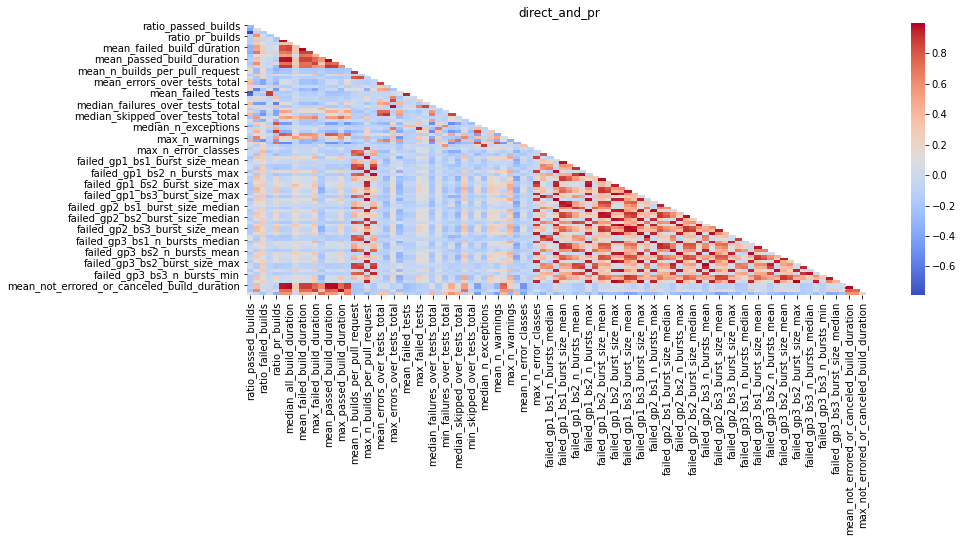

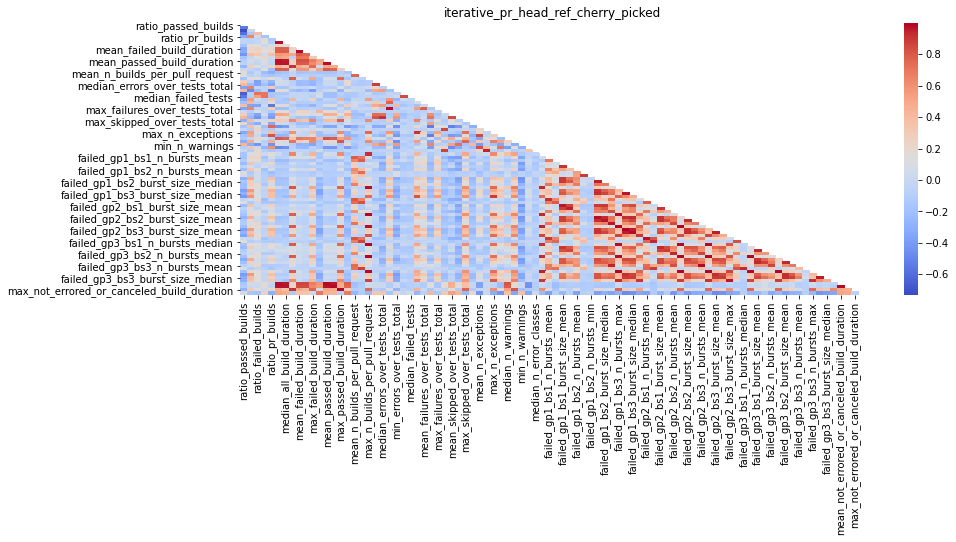

In [363]:
for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

**Do datasets have same columns?**

In [364]:
set(methods_indep_var[methods[0]]).difference(set(methods_indep_var[methods[1]]))

{'failed_gp1_bs1_n_bursts_max',
 'failed_gp1_bs2_burst_size_max',
 'failed_gp1_bs2_n_bursts_max',
 'failed_gp2_bs1_n_bursts_max',
 'failed_gp2_bs2_burst_size_max',
 'failed_gp3_bs2_burst_size_max',
 'failed_gp3_bs3_n_bursts_min',
 'min_n_builds_per_pull_request'}

### Normal distribution

In [365]:
method_normal_distributed_features = {}
for method in methods:
    shapiro_feat = methods_indep_var[method].apply(lambda x: shapiro(x)).T
    shapiro_feat.columns = ["statistic", "pval"]
    normal_feat = methods_indep_var[method].apply(lambda x: normaltest(x)).T
    normal_feat.columns = ["statistic", "pval"]
    method_normal_distributed_features[method] = list(shapiro_feat[shapiro_feat.pval > 0.05].index)\
    + list(normal_feat[normal_feat.pval > 0.05].index)

<AxesSubplot:ylabel='Frequency'>

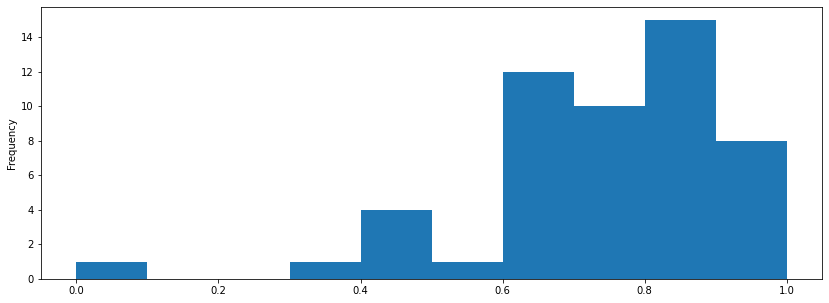

In [366]:
methods_indep_var[methods[1]].ratio_passed_builds.plot(kind="hist")

<Figure size 1008x360 with 0 Axes>

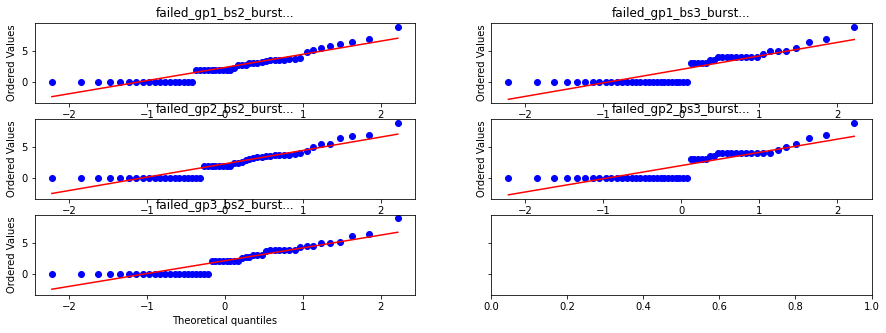

In [367]:
plt.figure()
for method in methods:
    df = methods_indep_var[method]
    normal_features = method_normal_distributed_features[method]
    if(len(normal_features) < 1):
        continue
    fig, axes = plt.subplots(nrows=3, ncols=int(len(normal_features)/3)+1, sharey=True, figsize=(15.0, 5.0))
    axes = axes.flatten()
    for i, feat in enumerate(normal_features):
        scipy.stats.probplot(df[feat], dist="norm", plot=axes[i])
        axes[i].set_title(feat[:20]+"...")
plt.savefig(f"{figure_folder}/dataset_preprocessing/qq-plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

A visual test does not seem to confirm that these features are indeed normally distributed. We conclude that none of our features are normally distributed.

### Correlated features

<Figure size 1008x360 with 0 Axes>

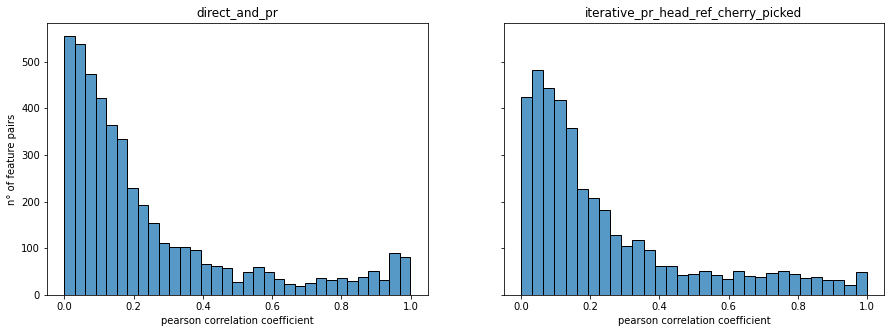

In [368]:
plt.figure()
methods_correlated_features = {}
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15.0, 5.0))
for i, method in enumerate(methods):
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_correlated_features[method] = sol[sol > 0.8]
    ax = sns.histplot(sol, ax=axes[i])
    ax.set_title(method)
    ax.set(xlabel="pearson correlation coefficient",ylabel="n° of feature pairs")
plt.savefig(f"{figure_folder}/dataset_preprocessing/correlated_feature_dist.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [369]:
methods_correlated_features[methods[1]].head(10)

failed_gp2_bs2_n_bursts_max    failed_gp3_bs2_n_bursts_max                   0.999
max_n_builds_per_pull_request  failed_gp3_bs1_n_bursts_max                   0.999
failed_gp2_bs3_n_bursts_max    failed_gp3_bs3_n_bursts_max                   0.999
failed_gp1_bs3_n_bursts_max    failed_gp2_bs3_n_bursts_max                   0.998
max_passed_build_duration      max_not_errored_or_canceled_build_duration    0.998
failed_gp3_bs1_n_bursts_max    failed_gp3_bs2_n_bursts_max                   0.997
failed_gp2_bs2_n_bursts_max    failed_gp3_bs1_n_bursts_max                   0.997
failed_gp1_bs3_n_bursts_max    failed_gp3_bs3_n_bursts_max                   0.996
max_n_builds_per_pull_request  failed_gp3_bs2_n_bursts_max                   0.996
                               failed_gp2_bs2_n_bursts_max                   0.995
dtype: float64

In [370]:
methods_correlated_features[methods[0]].head(10)

failed_gp1_bs1_n_bursts_max    failed_gp3_bs1_n_bursts_max                    0.999
failed_gp2_bs1_n_bursts_max    failed_gp3_bs1_n_bursts_max                    0.999
failed_gp1_bs1_n_bursts_max    failed_gp2_bs1_n_bursts_max                    0.998
failed_gp2_bs2_burst_size_max  failed_gp2_bs3_burst_size_max                  0.998
failed_gp3_bs2_burst_size_max  failed_gp3_bs3_burst_size_max                  0.998
failed_gp1_bs2_burst_size_max  failed_gp1_bs3_burst_size_max                  0.998
failed_gp1_bs2_n_bursts_max    failed_gp2_bs2_n_bursts_max                    0.997
mean_passed_build_duration     mean_not_errored_or_canceled_build_duration    0.997
failed_gp2_bs2_n_bursts_max    failed_gp3_bs2_n_bursts_max                    0.996
failed_gp2_bs3_n_bursts_mean   failed_gp3_bs3_n_bursts_mean                   0.995
dtype: float64

### Correlation with dependent variable
https://dataschool.com/fundamentals-of-analysis/correlation-and-p-value/

We proceed with analysing the correlation of our attributed with the three software quality metricsm
We calculate both types of correlation:
* Pearons (linear)
* Spearman (monotonic, is pearson applied to ranks)

https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/#:~:text=The%20Pearson%20correlation%20evaluates%20the%20linear%20relationship%20between%20two%20continuous%20variables.&text=The%20Spearman%20correlation%20coefficient%20is,evaluate%20relationships%20involving%20ordinal%20variables.

In [371]:
methods_pearson_corr_post_release_bugs = {}
methods_spearman_corr_post_release_bugs = {}
for method in methods:
    data = []
    corr_col = methods_dep_var[method].post_release_bugs
    x = methods_indep_var[method].apply(lambda x:\
                                scipy.stats.pearsonr(x, corr_col)).T
    x.columns = ["pearson_corr", "pval"]
    methods_pearson_corr_post_release_bugs[method] = x

    x = methods_indep_var[method].apply(lambda x:\
                                scipy.stats.spearmanr(x, corr_col)).T
    x.columns = ["spearman_corr", "pval"]
    methods_spearman_corr_post_release_bugs[method] = x

**Feature category correlation per each dataset**

In [372]:
feature_categories = ["ratio_(.*)_builds",
                     "(.*)_(.*)_build_duration",
                     "(.*)_n_builds_per_pull_request",
                     "(.*)_errors_over_tests_total",
                     "(.*)_failed_tests",
                     "(.*)_failures_over_tests_total",
                     "(.*)_skipped_over_tests_total",
                     "(.*)_n_exceptions",
                     "(.*)_n_warnings",
                     "(.*)_n_error_classes",
                     #"(.*)_burst_size",
                     "(.*)burst"]

In [373]:
import re
for cat in feature_categories:
    print("-"*10)
    print(cat)
    for method in methods:
        x = methods_pearson_corr_post_release_bugs[method]
        x = x[x.pval < 0.05].round(2)
        print(method, "\n", x[[True if re.search(cat, s) else False for s in x.index]]\
              .pearson_corr.sort_values(ascending=False).to_latex())

----------
ratio_(.*)_builds
direct_and_pr 
 \begin{tabular}{lr}
\toprule
Empty DataFrame
Columns: Index(['pearson\_corr'], dtype='object')
Index: Index([], dtype='object') \\
\bottomrule
\end{tabular}

iterative_pr_head_ref_cherry_picked 
 \begin{tabular}{lr}
\toprule
{} &  pearson\_corr \\
\midrule
ratio\_canceled\_builds &          0.40 \\
ratio\_passed\_builds   &         -0.43 \\
\bottomrule
\end{tabular}

----------
(.*)_(.*)_build_duration
direct_and_pr 
 \begin{tabular}{lr}
\toprule
{} &  pearson\_corr \\
\midrule
min\_not\_errored\_or\_canceled\_build\_duration &         -0.35 \\
\bottomrule
\end{tabular}

iterative_pr_head_ref_cherry_picked 
 \begin{tabular}{lr}
\toprule
{} &  pearson\_corr \\
\midrule
min\_not\_errored\_or\_canceled\_build\_duration &         -0.31 \\
\bottomrule
\end{tabular}

----------
(.*)_n_builds_per_pull_request
direct_and_pr 
 \begin{tabular}{lr}
\toprule
{} &  pearson\_corr \\
\midrule
max\_n\_builds\_per\_pull\_request &           0.5 \\
\bottomrul

In [374]:
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
spearman_corr.head(30)

max_failed_tests                    0.604831
max_n_builds_per_pull_request       0.581404
mean_failed_tests                   0.553903
failed_gp3_bs1_n_bursts_max         0.528155
failed_gp2_bs2_n_bursts_max         0.511154
failed_gp3_bs3_n_bursts_max         0.496669
failed_gp2_bs3_n_bursts_max         0.496523
failed_gp1_bs3_n_bursts_max         0.492640
failed_gp3_bs3_burst_size_max       0.490972
failed_gp2_bs3_burst_size_max       0.490442
failed_gp3_bs2_n_bursts_max         0.485250
failed_gp1_bs3_burst_size_max       0.476184
failed_gp1_bs2_n_bursts_mean        0.447691
max_failed_build_duration           0.442413
failed_gp1_bs1_n_bursts_mean        0.441807
failed_gp3_bs3_burst_size_mean      0.433230
max_n_error_classes                 0.416540
median_skipped_over_tests_total    -0.414252
failed_gp1_bs1_burst_size_mean      0.414210
max_n_exceptions                    0.412258
ratio_passed_builds                -0.402567
failed_gp1_bs3_burst_size_mean      0.399491
mean_n_bui

In [375]:
spearman_corr[[col for col in spearman_corr.index if re.search("(.*)_(.*)_build_duration", col)]]

max_failed_build_duration                     0.442413
min_not_errored_or_canceled_build_duration   -0.313496
Name: spearman_corr, dtype: float64

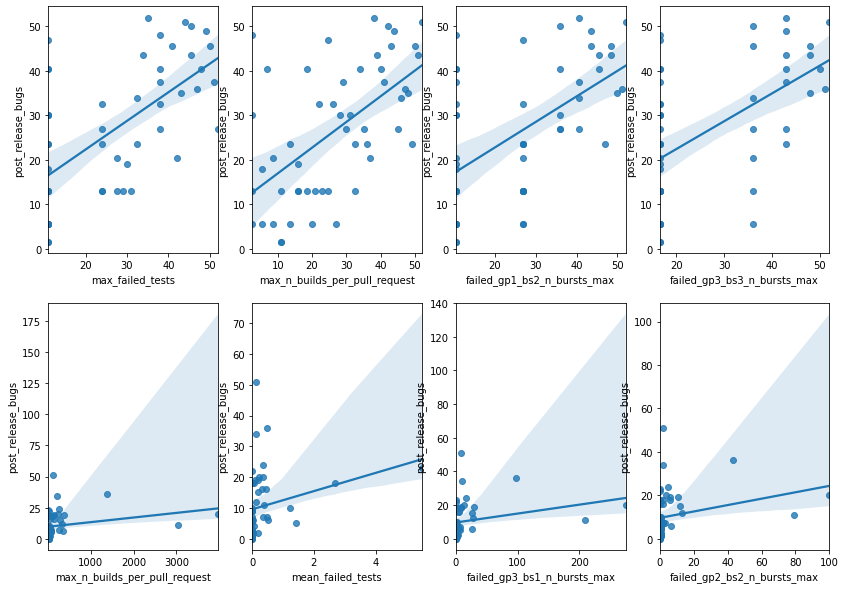

In [376]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14.0, 10.0))
axes = axes.flatten()

corr = methods_spearman_corr_post_release_bugs[methods[0]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
for i in range(4):
    feature = spearman_corr.index[i]
    sns.regplot(x=methods_indep_var[methods[0]][feature].rank(),
                   y=methods_dep_var[methods[0]].post_release_bugs.rank(), ax=axes[i])
    
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
for j in range(i+1, 8):
    feature = spearman_corr.index[j-i]
    sns.regplot(x=methods_indep_var[methods[1]][feature],
                   y=methods_dep_var[methods[1]].post_release_bugs, ax=axes[j])

df = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

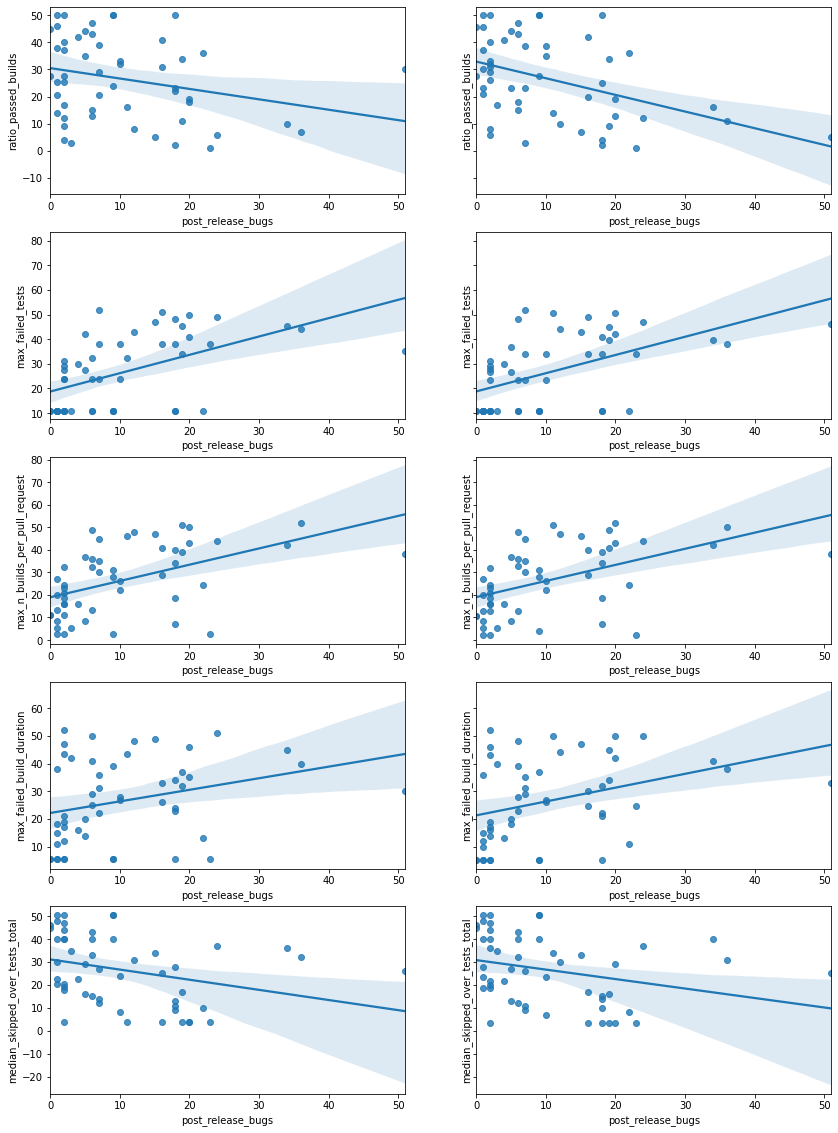

In [377]:
columns = ["ratio_passed_builds", "max_failed_tests",\
          "max_n_builds_per_pull_request", "max_failed_build_duration", "median_skipped_over_tests_total"]
fig, axes = plt.subplots(nrows=len(columns), ncols=2, sharey='row', figsize=(14.0, 4*len(columns)))
axes = axes.flatten()
i = 0
for col in columns:
    df_ind = methods_indep_var[methods[0]]
    df_dep = methods_dep_var[methods[0]]
    sns.regplot(y=df_ind[col].rank(), x=df_dep.post_release_bugs, ax=axes[i])
    i+=1
    df_ind = methods_indep_var[methods[1]]
    df_dep = methods_dep_var[methods[1]]
    sns.regplot(y=df_ind[col].rank(), x=df_dep.post_release_bugs, ax=axes[i])
    i+=1

In [378]:
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
spearman_corr[spearman_corr.abs() > 0.35].index

Index(['max_failed_tests', 'max_n_builds_per_pull_request',
       'mean_failed_tests', 'failed_gp3_bs1_n_bursts_max',
       'failed_gp2_bs2_n_bursts_max', 'failed_gp3_bs3_n_bursts_max',
       'failed_gp2_bs3_n_bursts_max', 'failed_gp1_bs3_n_bursts_max',
       'failed_gp3_bs3_burst_size_max', 'failed_gp2_bs3_burst_size_max',
       'failed_gp3_bs2_n_bursts_max', 'failed_gp1_bs3_burst_size_max',
       'failed_gp1_bs2_n_bursts_mean', 'max_failed_build_duration',
       'failed_gp1_bs1_n_bursts_mean', 'failed_gp3_bs3_burst_size_mean',
       'max_n_error_classes', 'median_skipped_over_tests_total',
       'failed_gp1_bs1_burst_size_mean', 'max_n_exceptions',
       'ratio_passed_builds', 'failed_gp1_bs3_burst_size_mean',
       'mean_n_builds_per_pull_request', 'failed_gp2_bs3_burst_size_mean',
       'failed_gp1_bs2_burst_size_mean', 'failed_gp3_bs2_burst_size_mean',
       'failed_gp2_bs2_n_bursts_mean', 'failed_gp1_bs3_n_bursts_mean',
       'failed_gp3_bs3_n_bursts_mean', 'failed_

cols = ['max_failed_tests', 'max_n_builds_per_pull_request',
       'mean_failed_tests', 'failed_gp3_bs1_n_bursts_max',
       'failed_gp3_bs3_burst_size_max', 'max_failed_build_duration',
       'max_n_error_classes', 'median_skipped_over_tests_total',
       'failed_gp1_bs1_burst_size_mean', 'max_n_exceptions',
       'ratio_passed_builds','mean_n_builds_per_pull_request',
        'min_skipped_over_tests_total', 'max_failures_over_tests_total']
df = methods_indep_var[methods[1]][cols].corr(method="spearman")
cols = []
matrix = np.triu(df) 
ax = sns.heatmap(df, cmap= 'coolwarm', mask=matrix, annot=True) 
#ax.set_title(method) 
plt.show()

<AxesSubplot:>

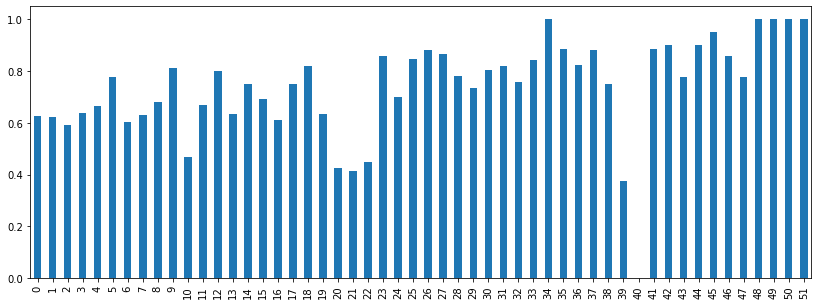

In [379]:
methods_indep_var[methods[1]].ratio_passed_builds.plot(kind="bar")

<AxesSubplot:>

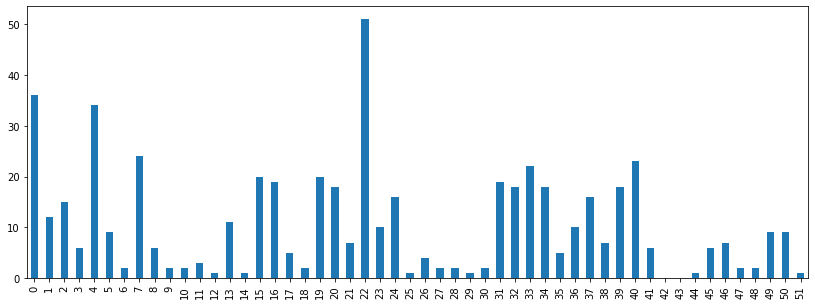

In [380]:
methods_dep_var[methods[1]].post_release_bugs.plot(kind="bar")

<AxesSubplot:>

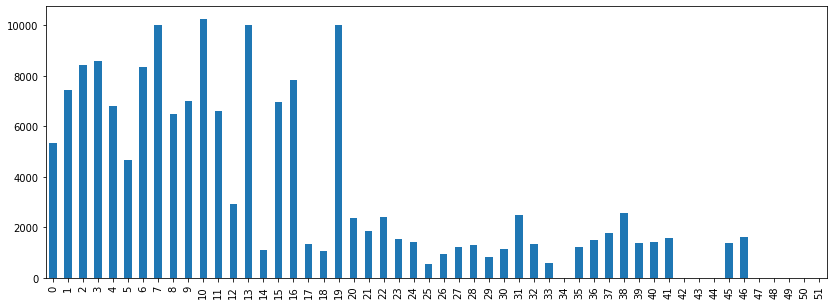

In [381]:
methods_indep_var[methods[1]].max_failed_build_duration.plot(kind="bar")

In [382]:
methods_indep_var[methods[1]].max_failed_build_duration.corr(\
                        methods_indep_var[methods[1]].min_not_errored_or_canceled_build_duration, method="spearman")

-0.29091316362019837

In [383]:
tags = tags[tags.jira_version.isin(direct_and_pr.to_tag)].reset_index(drop=True)
tags_gradle = tags[(tags.year>2018) & (tags.month>3)]
tags_gradle

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
29,NaN,6.7.7,4aa6d928f960303eb990d50c275513a517c85e69,2019-04-16 15:38:04,4,2019,6,6.7.7
38,2019-06-19 00:00:00,7.8,870ae4efbf5dcdbe59295eb5827b55a6a74c7b89,2019-06-18 09:08:04,6,2019,7,7.8
39,2019-07-01 00:00:00,7.9,6502ec4ffee7e5a57498baaf330b80eb490d01c2,2019-07-01 07:56:26,7,2019,7,7.9
40,NaN,7.9.1,6818fad17ba67e97d395a8488d5412e00892d5e1,2019-07-10 12:20:33,7,2019,7,7.9.1
41,NaN,7.9.2,5832fefc31f5ba25f15b3fa66ed816f7b87fd835,2019-12-09 13:03:50,12,2019,7,7.9.2
43,NaN,7.9.4,2f8d99a55899105cbf3e3170194c614c2a6ea4d7,2020-07-23 14:40:10,7,2020,7,7.9.4
44,2019-10-16 00:00:00,8.0,87ca68d63f4afd37d74b2f454430dfde9e862c6a,2019-10-15 08:15:12,10,2019,8,8.0
45,2019-12-16 00:00:00,8.1.0.31237,65a7a7c34de5bff9aed7c3e58eb6dcc87ae34b57,2019-12-17 12:29:34,12,2019,8,8.1
47,2020-04-30 00:00:00,8.3.0.34182,9c58e36328ae79ad3c36c13aa253879351ce3613,2020-04-28 13:54:13,4,2020,8,8.3
48,NaN,8.3.1.34397,b77ce511a2039330aea8832ad12e86a8cfa9ff7d,2020-05-07 12:09:22,5,2020,8,8.3.1


**Remove highly correlated features?**

In [384]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    print(method, len(methods_correlated_features[method]))
    corr_matrix = methods_indep_var[method].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    methods_corr_cols_to_remove[method] = [column for column in upper.columns if any(upper[column] > 0.95)]

direct_and_pr 341
iterative_pr_head_ref_cherry_picked 216


In [385]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(52, 54)
(52, 63)


for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

### Play with feature selection

In [540]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, RFECV
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, make_scorer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [512]:
regression_mask = all_mask
cross_validation_strategy = KFold(5, shuffle=True, random_state=1)

In [476]:
method_x_train = {}
method_y_train = {}
method_train_columns = {}
for method in methods:
    X_train = methods_indep_var[method][regression_mask]
    y_train = methods_dep_var[method].post_release_bugs[regression_mask]
    train_columns = X_train.columns
    X_train[X_train.columns] = StandardScaler().fit_transform(X_train)
    method_x_train[method] = X_train
    method_y_train[method] = y_train
    method_train_columns[method] = train_columns

In [409]:
def two_layer_cross_validate(model, params_grid, x, y, num_trials, n_splits, scoring=None):
    nested_scores = np.zeros(num_trials)
    for i in range(num_trials):
        inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=i)

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=model, param_grid=params_grid, cv=inner_cv)
        """clf.fit(method_x_train[methods[1]], method_y_train[methods[1]])
        non_nested_scores[i] = clf.best_score_
        """
        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, x, y, cv=outer_cv, scoring=scoring)
        nested_scores[i] = nested_score.mean()
    return nested_scores

In [424]:
def outer_layer_cross_validate(model, x, y, num_trials, n_splits, scoring=None):
    nested_scores = np.zeros(num_trials)
    for i in range(num_trials):
        outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=i)
        # Nested CV with parameter optimization
        nested_score = cross_val_score(model, x, y, cv=outer_cv, scoring=scoring)
        nested_scores[i] = nested_score.mean()
    return nested_scores

In [643]:
def forward_feature_selection(model, X, y, cv=5, scoring="r2"):
    best_performance = -100
    added_columns = set()
    while(True):
        #print("Best perf", best_performance)
        current_perf = best_performance
        curr_col = None
        for col in X.columns:
            if col in added_columns:
                continue
            perf = cross_val_score(model, X[added_columns.union(set([col]))],\
                                   y, cv=cv, scoring=scoring)
            #print(added_columns.union(set([col])), perf.mean())
            if current_perf < perf.min():
                current_perf = perf.min()
                curr_col = col
        if current_perf <= best_performance:
            break
        else:
            best_performance = current_perf
            added_columns.add(curr_col)
            #print(added_columns)
    return added_columns, best_performance

**Regression**

In [554]:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 4)]
max_features = ['auto', 'sqrt']
max_depth = [10, 50, 100]
max_depth.append(None)
params_grid = {'max_features': max_features,
               "max_depth" : max_depth
              }

model = DecisionTreeRegressor()
method_randomregressor_r2 = {}
method_randomregressor_neg_mean_error = {}
for method in methods:
    method_randomregressor_r2[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_train[method], 5, 5, "r2")
    method_randomregressor_neg_mean_error[method] = \
        two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_train[method], 5, 5, "neg_mean_absolute_error")

In [555]:
for method in methods:
    print("R2","-"*40)
    print(method, method_randomregressor_r2[method])
    print("Nmae","-"*40)
    print(method, method_randomregressor_neg_mean_error[method])

R2 ----------------------------------------
direct_and_pr [-2.71253562 -1.32422569 -1.26327504 -1.15940415 -1.04957468]
Nmae ----------------------------------------
direct_and_pr [-6.52554113 -7.72363636 -8.14363636 -8.62909091 -7.35454545]
R2 ----------------------------------------
iterative_pr_head_ref_cherry_picked [-0.29220157  0.02362583 -4.11159949 -0.78079429 -1.18836421]
Nmae ----------------------------------------
iterative_pr_head_ref_cherry_picked [-7.19090909 -7.04863636 -8.89454545 -9.13272727 -9.29636364]


In [556]:
method_knn_regr_features = {}
for method in methods:
    features, score = forward_feature_selection(KNeighborsRegressor(), method_x_train[method],\
                                           method_y_train[method], cv=cross_validation_strategy)
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_regr_features[method] = features

--------------------
direct_and_pr {'max_n_exceptions', 'mean_failed_tests', 'min_skipped_over_tests_total', 'max_all_build_duration', 'min_n_builds_per_pull_request'} 0.2593568912623565
--------------------
--------------------
iterative_pr_head_ref_cherry_picked {'median_n_exceptions', 'min_skipped_over_tests_total', 'max_failed_tests'} 0.1768308115543329
--------------------


In [557]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)],
              'p': [1,2,3]}
model = KNeighborsRegressor()
method_knregressor_r2 = {}
method_knregressor_neg_mean_error = {}
for method in methods:
    x = method_x_train[method][method_knn_regr_features[method]]
    method_knregressor_r2[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 5, "r2")
    method_knregressor_neg_mean_error[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 5, "neg_mean_absolute_error")

In [558]:
for method in methods:
    print(method, method_knregressor_r2[method])
    print(method, method_knregressor_neg_mean_error[method])

direct_and_pr [ 0.05021978 -0.08333946 -0.35524853  0.16191121  0.11920788]
direct_and_pr [-6.47558442 -7.5370303  -6.0870303  -6.64405195 -6.17090909]
iterative_pr_head_ref_cherry_picked [-0.28860645  0.17707513 -0.80032714 -0.18559908 -0.34533356]
iterative_pr_head_ref_cherry_picked [-7.18493506 -6.9109697  -7.07381818 -7.77160173 -7.44379221]


In [559]:
"""def forward_cross_validation(model, X, y):
    best_performance = cross_val_score(DummyRegressor(strategy="mean"), X, y, scoring="neg_mean_absolute_error").mean()
    added_columns = set()
    while(True):
        print("Best perf", best_performance)
        current_perf = best_performance
        curr_col = None
        for col in X.columns:
            if col in added_columns:
                continue
            perf = cross_val_score(model, X[added_columns.union(set([col]))], y, scoring="neg_mean_absolute_error")
            print(added_columns.union(set([col])), perf.mean())
            if current_perf < perf.mean():
                current_perf = perf.mean()
                curr_col = col
        print("end cycle", col, current_perf)
        if current_perf <= best_performance:
            break
        else:
            best_performance = current_perf
            added_columns.add(curr_col)
            print(added_columns)
    return added_columns, best_performance"""

'def forward_cross_validation(model, X, y):\n    best_performance = cross_val_score(DummyRegressor(strategy="mean"), X, y, scoring="neg_mean_absolute_error").mean()\n    added_columns = set()\n    while(True):\n        print("Best perf", best_performance)\n        current_perf = best_performance\n        curr_col = None\n        for col in X.columns:\n            if col in added_columns:\n                continue\n            perf = cross_val_score(model, X[added_columns.union(set([col]))], y, scoring="neg_mean_absolute_error")\n            print(added_columns.union(set([col])), perf.mean())\n            if current_perf < perf.mean():\n                current_perf = perf.mean()\n                curr_col = col\n        print("end cycle", col, current_perf)\n        if current_perf <= best_performance:\n            break\n        else:\n            best_performance = current_perf\n            added_columns.add(curr_col)\n            print(added_columns)\n    return added_columns, best_pe

In [635]:
method_lin_regr_features = {}
for method in methods:
    features, score = forward_feature_selection(LinearRegression(), method_x_train[method],\
                                           method_y_train[method], cv=cross_validation_strategy)
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_lin_regr_features[method] = features

--------------------
direct_and_pr {'mean_failed_tests', 'max_n_builds_per_pull_request', 'min_skipped_over_tests_total', 'min_failures_over_tests_total', 'failed_gp3_bs3_burst_size_mean'} 0.3432914484933548
--------------------
--------------------
iterative_pr_head_ref_cherry_picked {'failed_gp1_bs2_n_bursts_mean', 'mean_failed_tests', 'min_failed_build_duration', 'failed_gp1_bs1_n_bursts_median', 'mean_n_warnings', 'min_skipped_over_tests_total', 'failed_gp3_bs1_burst_size_median', 'failed_gp2_bs3_burst_size_max', 'failed_gp3_bs3_burst_size_mean', 'failed_gp3_bs2_burst_size_median'} 0.3992003588552414
--------------------


In [636]:
method_lin_regr_r2 = {}
method_linregression_nmae = {}
for method in methods:
    features = method_lin_regr_features[method]
    method_linregression_r2[method] = outer_layer_cross_validate(LinearRegression(), method_x_train[method][features],\
                    method_y_train[method], 5, 5, scoring="r2")
    method_linregression_nmae[method] = outer_layer_cross_validate(LinearRegression(), method_x_train[method][features],\
                    method_y_train[method], 5, 5, scoring="neg_mean_absolute_error")

In [637]:
for method in methods:
    print("R2","-"*40)
    print(method, method_linregression_r2[method])
    print("Nmae","-"*40)
    print(method, method_linregression_nmae[method])

R2 ----------------------------------------
direct_and_pr [ 0.08995375  0.34329145 -0.5618827  -2.8021152  -0.3898495 ]
Nmae ----------------------------------------
direct_and_pr [-6.68895613 -5.94692591 -6.77407902 -9.00212649 -7.39705299]
R2 ----------------------------------------
iterative_pr_head_ref_cherry_picked [-0.52478454  0.39920036 -0.60638621 -0.7878907  -0.44161884]
Nmae ----------------------------------------
iterative_pr_head_ref_cherry_picked [-7.64633442 -5.9743187  -7.36396912 -8.50211057 -8.04120682]


is_small = y_train < y_train.quantile(.25)
is_large = y_train > y_train.quantile(.75)
is_medium = ~(is_small | is_large)

y_quantiles = y_train.mask(is_small, 'small').mask(is_large, 'large').mask(is_medium, 'medium')

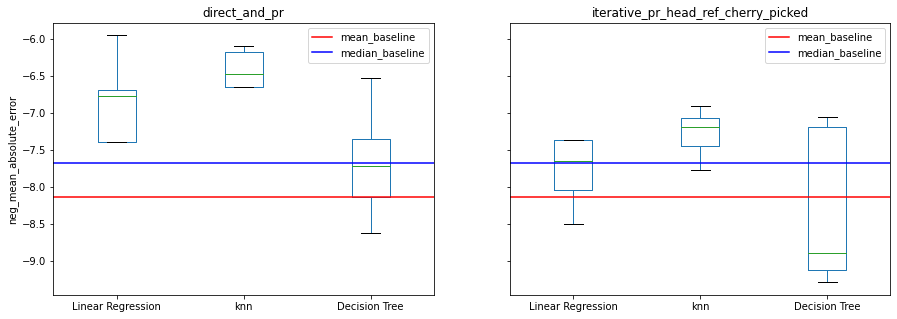

<Figure size 1008x360 with 0 Axes>

In [638]:
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
plt.figure()
scores = {"Linear Regression":method_linregression_nmae,
          "knn": method_knregressor_neg_mean_error,
          "Decision Tree": method_randomregressor_neg_mean_error
         }
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", showfliers=False, ax=axes[i])
    x = method_x_train[method]
    y = method_y_train[method]
    ax.axhline(y=-mean_absolute_error(DummyRegressor(strategy="mean").fit(x, y).predict(y), y),color='r', label="mean_baseline")
    ax.axhline(y=-mean_absolute_error(DummyRegressor(strategy="median").fit(x, y).predict(y), y),color='b', label="median_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="neg_mean_absolute_error")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/regression_neg_mean_absolute_error.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

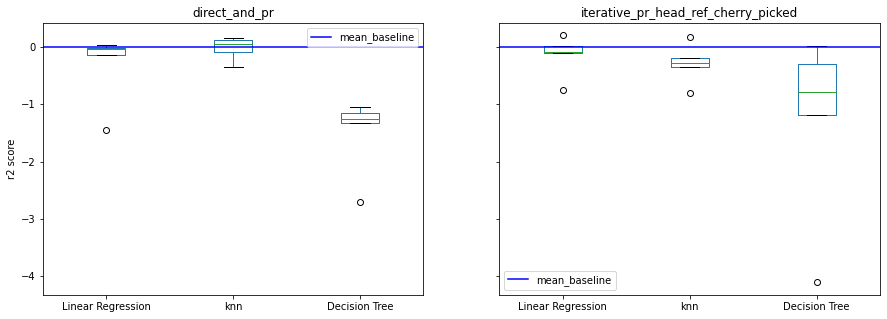

<Figure size 1008x360 with 0 Axes>

In [620]:
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
plt.figure()
scores = {"Linear Regression":method_linregression_r2,
          "knn": method_knregressor_r2, 
          "Decision Tree": method_randomregressor_r2
         }
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    y = method_y_train[method]
    #ax.axhline(y=r2_score(DummyRegressor(strategy="mean").fit(x, y).predict(y), y),color='r', label="mean_baseline")
    ax.axhline(y=r2_score(DummyRegressor(strategy="median").fit(x, y).predict(y), y),color='b', label="mean_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="r2 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/regression_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

### Binary

In [623]:
method_y_bin_train = {}
for method in methods:
    method_y_bin_train[method] = method_y_train[method] > method_y_train[method].median()

In [624]:
max_features = ['auto', 'sqrt']
max_depth = [10, 50, 100]
max_depth.append(None)
params_grid = {'max_features': max_features,
               "max_depth" : max_depth
              }

model = DecisionTreeClassifier()
method_randomclassifier_binary_f1 = {}
for method in methods:
    method_randomclassifier_binary_f1[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 5, "f1")

In [566]:
for method in methods:
    print(method, method_randomclassifier_binary_f1[method])

direct_and_pr [0.42878788 0.62301587 0.45194805 0.45439005 0.65858586]
iterative_pr_head_ref_cherry_picked [0.49777778 0.54722222 0.43818182 0.55463203 0.54603175]


In [639]:
method_knn_bin_features = {}
for method in methods:
    features, score = forward_feature_selection(KNeighborsClassifier(), method_x_train[method],\
                                           method_y_bin_train[method], cv=cross_validation_strategy, scoring="f1")
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_bin_features[method] = features

--------------------
direct_and_pr {'median_errors_over_tests_total', 'max_failed_tests'} 0.7310101010101009
--------------------
--------------------
iterative_pr_head_ref_cherry_picked {'mean_failed_tests', 'max_failed_tests', 'min_n_warnings', 'min_skipped_over_tests_total', 'mean_n_builds_per_pull_request'} 0.7711111111111111
--------------------


In [640]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)],
              'p': [1,2,3]}
model = KNeighborsClassifier()
method_knregressor_f1 = {}
for method in methods:
    
    y_bin = method_y_train[method] > method_y_train[method].median()
    method_knregressor_f1[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 5, "f1")

In [641]:
for method in methods:
    print(method, method_knregressor_f1[method])

direct_and_pr [0.70545455 0.74666667 0.53030303 0.64920635 0.61428571]
iterative_pr_head_ref_cherry_picked [0.45936508 0.61388889 0.53484848 0.6011544  0.62878788]


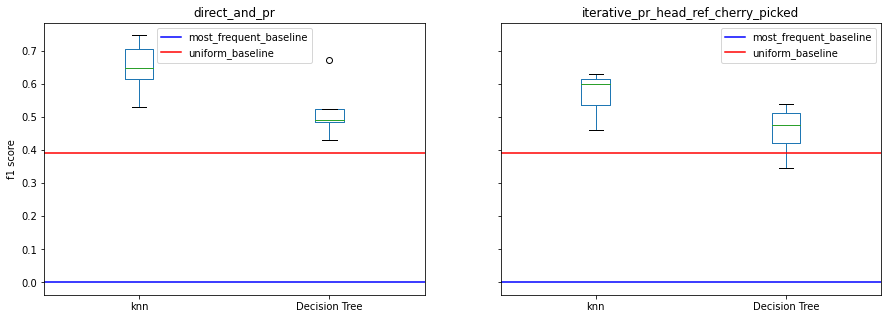

<Figure size 1008x360 with 0 Axes>

In [642]:
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
plt.figure()
scores = {"knn": method_knregressor_f1, 
          "Decision Tree": method_randomclassifier_binary_f1}
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=f1_score(DummyClassifier(strategy="most_frequent").fit(x, y_bin).predict(y_bin), y_bin), color="b", label="most_frequent_baseline")
    ax.axhline(y=f1_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="f1 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_f1.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**----------------------------------------**

### PCA

In [382]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X = methods_indep_var[methods[1]][mask]
X = StandardScaler().fit_transform(X)
y = methods_dep_var[methods[1]][mask].java_build_tool.reset_index(drop=True)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [383]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [392]:
pca.explained_variance_ratio_[:1].sum()

0.23559056005146486

<AxesSubplot:>

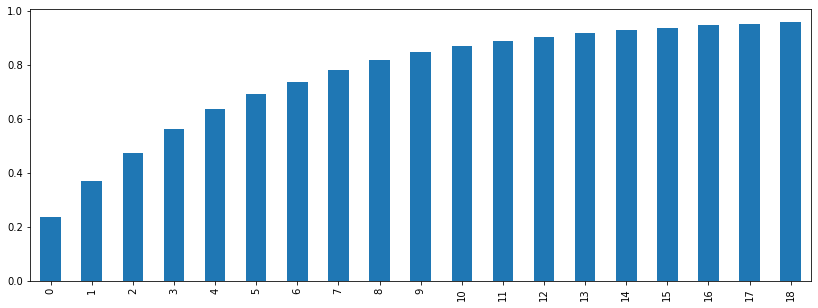

In [402]:
data = []
for i in range(1, len(pca.explained_variance_ratio_)):
    data.append((i, pca.explained_variance_ratio_[:i].sum()))
pd.DataFrame(data)[1].plot(kind="bar")

In [346]:
X_pca = pca.transform(X)

In [404]:
y_bugs = methods_dep_var[methods[1]].post_release_bugs

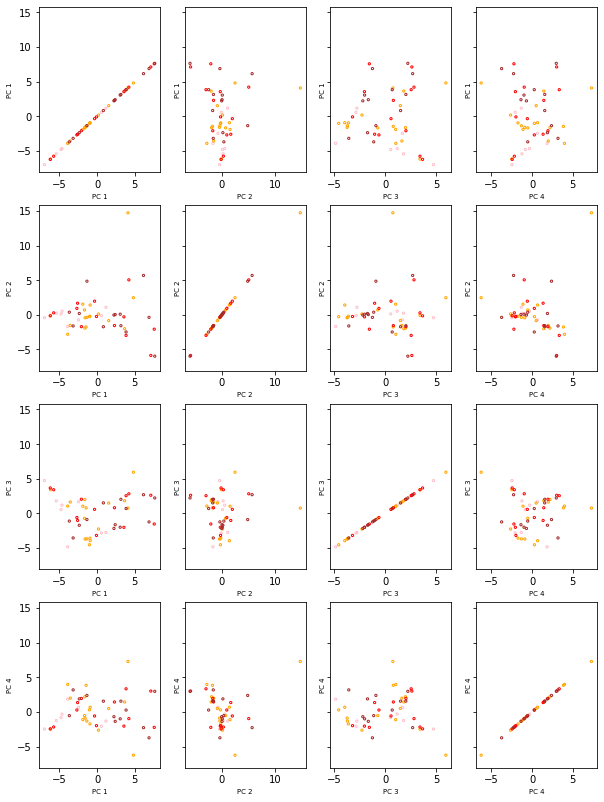

In [409]:
#plt.scatter(X_pca, y)
n_components = 4
fig, axes = plt.subplots(nrows=n_components, ncols=n_components, sharey=True, figsize=(10.0, 14.0))
for i in range(0,n_components):
    for j in range(0,n_components):
        ax = axes[i][j]
        ax.set_xlabel(f"PC {j+1}", fontsize = 7)
        ax.set_ylabel(f"PC {i+1}", fontsize = 7)
        colors = ["pink",'orange','red','brown','black']
        ranges = [(0,y_bugs.quantile(0.25)),(y_bugs.quantile(0.25),y_bugs.quantile(0.5))\
                  ,(y_bugs.quantile(0.5),y_bugs.quantile(0.75)), (y_bugs.quantile(0.75),y_bugs.quantile(1))]
        for rang, color in zip(ranges, colors):
            indicesToKeep = (y_bugs>=rang[0]) & (y_bugs<rang[1])
            ax.scatter(finalDf.loc[indicesToKeep, j],
                       finalDf.loc[indicesToKeep, i],
                       s = 5,
                       facecolors='none',
                       edgecolors=color)

In [421]:
df = pd.DataFrame(X)
df.columns = df.columns.astype(str)

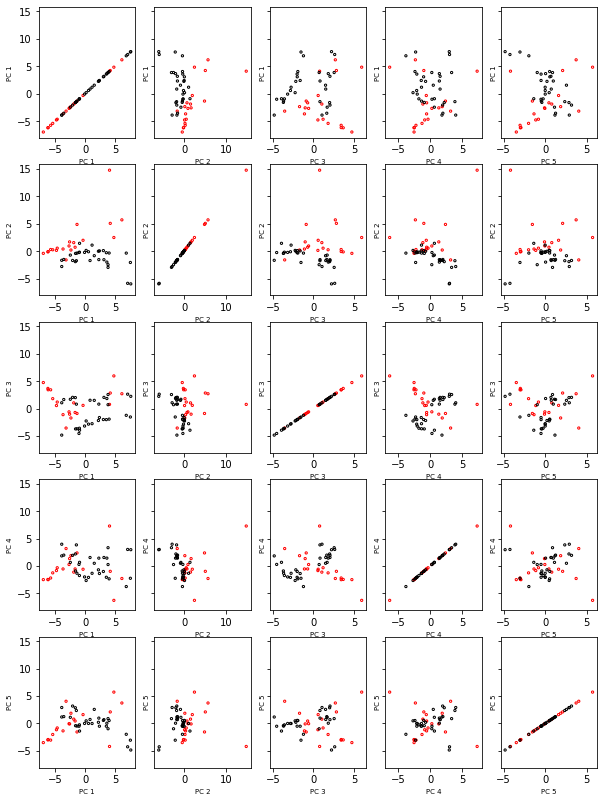

In [381]:
#plt.scatter(X_pca, y)
fig, axes = plt.subplots(nrows=5, ncols=5, sharey=True, figsize=(10.0, 14.0))
for i in range(0,5):
    for j in range(0,5):
        ax = axes[i][j]
        ax.set_xlabel(f"PC {j+1}", fontsize = 7)
        ax.set_ylabel(f"PC {i+1}", fontsize = 7)
        colors = ['r','black']
        ranges = ["gradle", "maven"]
        for rang, color in zip(ranges, colors):
            indicesToKeep = (y==rang)
            ax.scatter(finalDf.loc[indicesToKeep, j],
                       finalDf.loc[indicesToKeep, i],
                       s = 5,
                       facecolors='none',
                       edgecolors=color)